In [1]:
import cv2
import skimage.io
import numpy as np
import tkinter as tk
from tkinter import *
from helpers import *
from classes import *
from matplotlib import pyplot as plt
from tkinter import filedialog as fd
from tkinter import messagebox as mb

In [4]:
def get_backProjected(hemisphere, figsize=(16,9)):
    h = hemisphere.size[0]
    w = hemisphere.size[1]
    return hemisphere.backProjectedVector[:h*w].reshape((h,w))

def get_backProjectedRGB(hemisphere, figsize=(16,9)):
    h = hemisphere.size[0]
    w = hemisphere.size[1]
    R = hemisphere.backProjectedVector[0, :h*w]
    G = hemisphere.backProjectedVector[1, :h*w]
    B = hemisphere.backProjectedVector[2, :h*w]
    return np.dstack([R,G,B]).reshape((h,w,3))

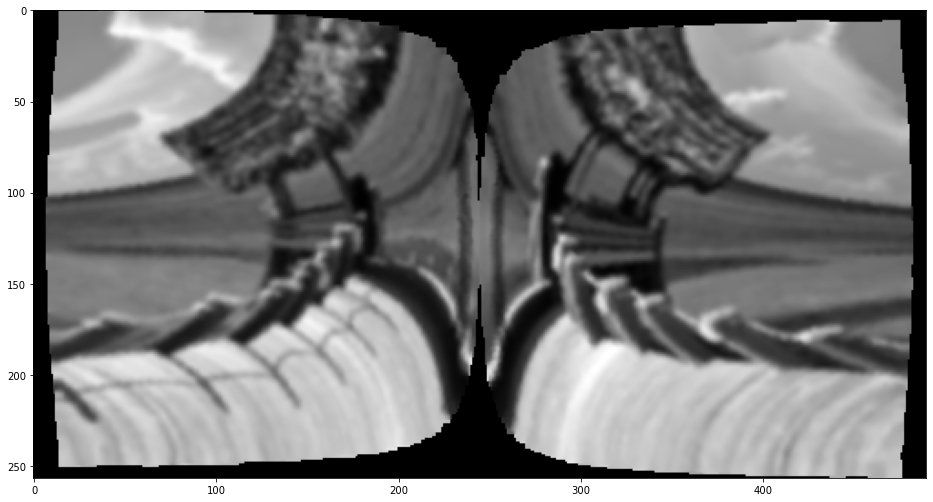

In [5]:
result = loadPickle('result.pkl')
resultRGB = loadPickle('result_rgb.pkl')

C = Cortex('left_path.pkl', 'right_path.pkl')
C.calibrate(result)
C.backProject(result)

L = get_backProjected(C.left_hemi)
R = get_backProjected(C.right_hemi)

cort_img = np.concatenate((L, R), axis=1)
plt.figure(figsize=(16,9))
plt.imshow(cort_img, cmap='gray')
plt.show()

In [6]:
%%timeit
C.backProject(result)

12.3 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


[[  0  59  60 ... 199 178 184]
 [  0 144 145 ... 185 186 189]
 [  0 167 166 ... 171 213 210]]


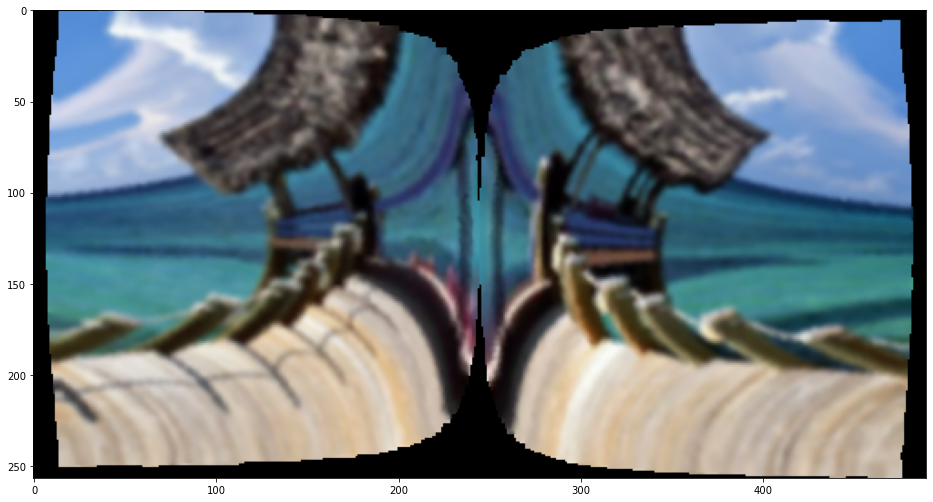

In [8]:
C.calibrate(resultRGB)
test = divideRGB(resultRGB, 101610.45469109702)
C.backProject(test)
print(test)

L = get_backProjectedRGB(C.left_hemi)
R = get_backProjectedRGB(C.right_hemi)

cort_img = np.concatenate((L, R), axis=1)

plt.figure(figsize=(16,9))
plt.imshow(cort_img)
plt.show()

In [9]:
%%timeit
C.backProject(resultRGB)

28.4 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
